Preprocessing...
Initial dataset sizes:
Dataset 'MacBookPro1' before preprocessing: 1000
Dataset 'MacBookPro2' before preprocessing: 1000
Dataset 'RaspberryPi' before preprocessing: 1000
Dataset 'VM' before preprocessing: 1000

Dataset types: Execution Time            float64
Hour                        int32
DayOfWeek                   int32
ServerType_MacBookPro1       bool
ServerType_MacBookPro2       bool
ServerType_RaspberryPi       bool
ServerType_VM                bool
dtype: object

Dataset duplicat rows before: 33

Dataset duplicat rows after: 0

Dataset after preprocessing checking for outliers via IQR method, missing value impute with median and combine datasets:  3934

Testing with test size: 0.1
Logistic Regression - Accuracy: 0.8604060913705583, F1 Score: 0.8644376022246654, Precision: 0.9023605447837785, Recall: 0.8604060913705583
Decision Tree - Accuracy: 0.8604060913705583, F1 Score: 0.8644376022246654, Precision: 0.9023605447837785, Recall: 0.8604060913705583
Random F

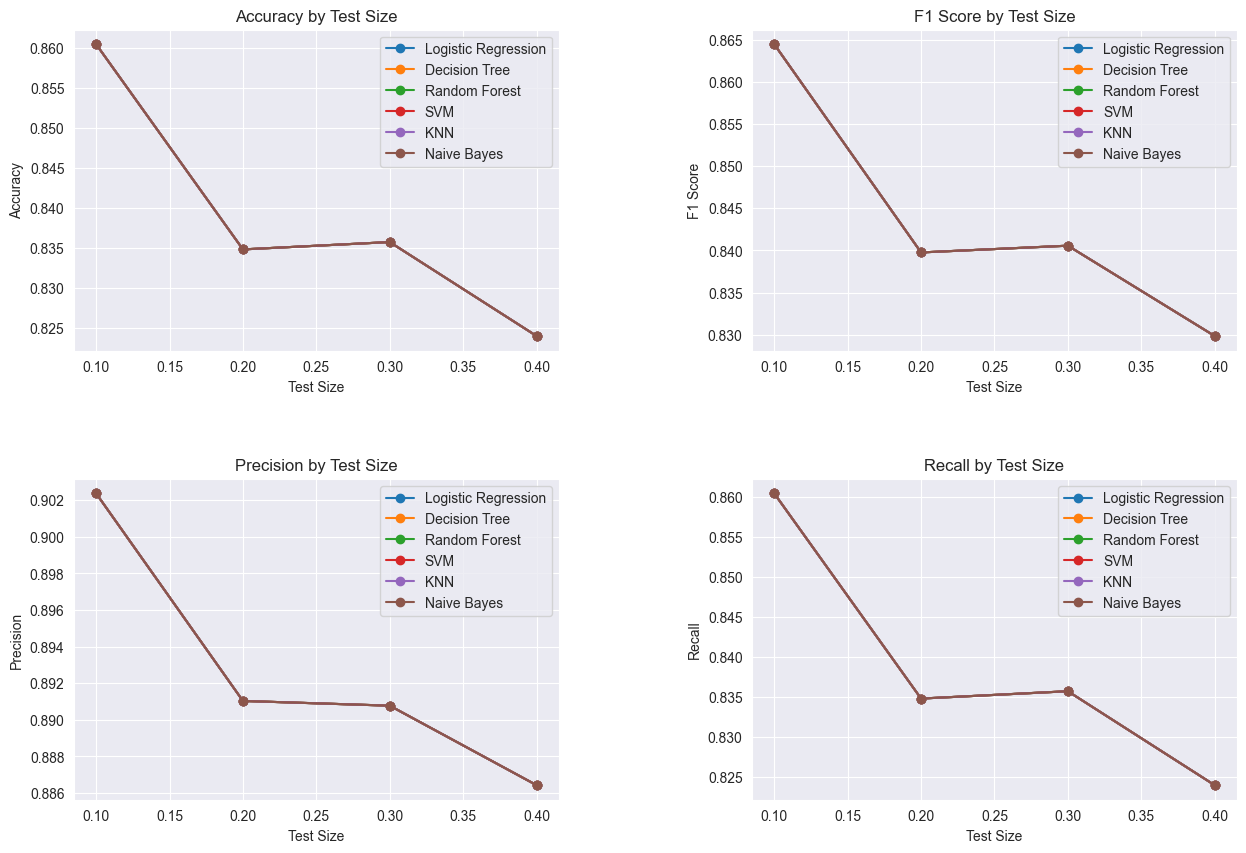

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer

# Load the datasets
df_macbook_pro1 = pd.read_csv('../datasets/MacBookPro1.csv')
df_macbook_pro2 = pd.read_csv('../datasets/MacBookPro2.csv')
df_raspberry_pi = pd.read_csv('../datasets/RaspberryPi.csv')
df_vm = pd.read_csv('../datasets/VM.csv')

# Pre-processing steps
datasets = [df_macbook_pro1, df_macbook_pro2, df_raspberry_pi, df_vm]
server_names = ['MacBookPro1', 'MacBookPro2', 'RaspberryPi', 'VM']

print("Preprocessing...")
print("Initial dataset sizes:")
for df, name in zip(datasets, server_names):
    print(f"Dataset '{name}' before preprocessing: {len(df)}")

for i, df in enumerate(datasets):
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy="most_frequent")
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = numeric_imputer.fit_transform(df[[col]])
        elif pd.api.types.is_string_dtype(df[col]) or isinstance(df[col].dtype, pd.CategoricalDtype):
            df[col] = categorical_imputer.fit_transform(df[[col]])
    df['Hour'] = df['Time'].dt.hour
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df['ServerType'] = server_names[i]

df_combined = pd.concat(datasets).reset_index(drop=True)
df_combined = pd.get_dummies(df_combined, columns=['ServerType'])
df_combined.drop('Time', axis=1, inplace=True)

print("")
print("Dataset types:", df_combined.dtypes)
print("")
print("Dataset duplicat rows before:", df_combined.duplicated().sum())
df_combined.drop_duplicates(keep= False, inplace= True)
print("")
print("Dataset duplicat rows after:", df_combined.duplicated().sum())
print("")
print("Dataset after preprocessing checking for outliers via IQR method, missing value impute with median and combine datasets: ", len(df_combined))


final_imputer = SimpleImputer(strategy='median')
df_combined = pd.DataFrame(final_imputer.fit_transform(df_combined), columns=df_combined.columns)

# Define bins and categorize execution times
percentile_bins = [df_combined['Execution Time'].min(), 
                   df_combined['Execution Time'].quantile(0.33), 
                   df_combined['Execution Time'].quantile(0.66), 
                   df_combined['Execution Time'].max()]
labels = ['fast', 'medium', 'slow']
df_combined['Execution Time Category'] = pd.cut(df_combined['Execution Time'], bins=percentile_bins, labels=labels, include_lowest=True)

X = df_combined.drop(['Execution Time', 'Execution Time Category'], axis=1)
y = df_combined['Execution Time Category']

split_ratios = [0.1, 0.2, 0.3, 0.4]
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Prepare to collect and visualize data
results = {name: [] for name in models}

# Testing different train-test splits
for test_size in split_ratios:
    print(f"\nTesting with test size: {test_size}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        metrics = {
            'Accuracy': accuracy_score(y_test, predictions),
            'F1 Score': f1_score(y_test, predictions, average='weighted'),
            'Precision': precision_score(y_test, predictions, average='weighted'),
            'Recall': recall_score(y_test, predictions, average='weighted')
        }
        results[name].append(metrics)
        print(f"{name} - Accuracy: {metrics['Accuracy']}, F1 Score: {metrics['F1 Score']}, Precision: {metrics['Precision']}, Recall: {metrics['Recall']}")

# Plotting results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.ravel()

metrics_list = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
for idx, metric in enumerate(metrics_list):
    for model in models:
        axes[idx].plot(split_ratios, [result[metric] for result in results[model]], marker='o', label=model)
    axes[idx].set_title(f'{metric} by Test Size')
    axes[idx].set_xlabel('Test Size')
    axes[idx].set_ylabel(metric)
    axes[idx].legend()

plt.show()
